# **Vanilla Policy Gradient & Introducing OpenAI Gym**

Environment: Lunar Lander

## References

#### Papers
- [High-Dimensional Continuous Control Using Generalized Advantage Estimation, Schulman et al, 2015. Algorithm: GAE.](https://arxiv.org/abs/1506.02438)

#### Blogs
- [OpenAI Spinning Up - Vanilla Policy Gradient](https://spinningup.openai.com/en/latest/algorithms/vpg.html)

#### Others
- [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/index.html)
- [OpenAI Gym](https://gym.openai.com/)
- [李宏毅 (Hung-yi Lee) - Deep Learning for Human Language Processing (2020,Spring)](http://speech.ee.ntu.edu.tw/~tlkagk/courses_ML20.html)

## Preparation

> First, we need to install required system packages as well as PyPi packages. "Gym" is a package provided by OpenAI as a toolkit for developing reinforcement learning algorithm. Other packages are used for visualization in Notebook.



In [22]:
%%capture
!sudo apt update
!sudo apt install python-opengl xvfb -y
!pip install gym[box2d] pyvirtualdisplay piglet tqdm

> Next, we need to import required packages and set up virtual display.



In [23]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm import tqdm_notebook

> Finally, import gym and create a [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment

In [24]:
%%capture
import gym
env = gym.make('LunarLander-v2')

### Lunar Lander
Lunar Lander is an environment simulates the process of lunar module landing on the moon. [(Source code)](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py)

> Let us check the contents of obervation/state, action and reward provieded by the environment.

In [4]:
# Observation/State
print("Observation/State: {}".format(env.observation_space))

# Action
print("Action: {}".format(env.action_space))

# Sample an action to get reward
initial_state = env.reset() # Get initial state
#print("State(initial): {}".format(initial_state))
random_action = env.action_space.sample() # Sample an action
# Reward
observation, reward, done, info = env.step(random_action)
print("Reward: {}".format(reward))

Observation/State: Box(8,)
Action: Discrete(4)
Reward: -0.03795372542119252


> The observation/state is an 8 dimension vector includes 


#### Demo: Random Agent
Here we randomly sample an action from the action space of the environment.

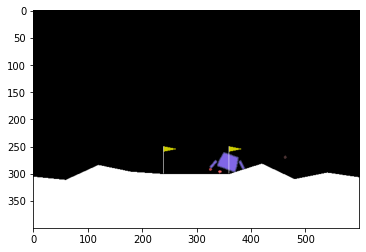

In [5]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## VPG Algorithm
Vanilla Policy Gradient

We implement simple VPG with simple discounted rewards.

\begin{equation}
\begin{split}
&\hat{g}_k = \frac{1}{\lvert{\mathcal{D}_k}\rvert} \sum_{\tau\in\mathcal{D}_k} \sum_{t=0}^{T} \nabla_\theta\ log \ \pi_{\theta}(a_t|s_t) |_{\theta_k} \hat{A}_t
\end{split}
\end{equation}

### Policy Gradient Network
> First, we build an simple policy network with input dimension 8 and output dimension 4.



In [25]:
class PGNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

### Value Function Network

In [26]:
class VFNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        hid = torch.tanh(self.fc3(hid))
        return self.fc4(hid)

### Vanilla Policy Gradient Agent
> Next, we build an simple agent which use the policy network above to take action and have the following functions:
1.   `update_pgnet()`: Update the policy network with log probabilities and rewards.
2.   `update_vfnet()`: Update the value function network.
3.   `sample()`: Sample an action and return the log probabilities by the policy network with the observation from the environment.


In [27]:
class PGAgent():

    def __init__(self, pgnet, vfnet):
        self.pgnet = pgnet
        self.vfnet = vfnet
        self.pg_optimizer = optim.SGD(self.pgnet.parameters(), lr=0.001)
        self.vf_optimizer = optim.SGD(self.vfnet.parameters(), lr=0.001)

    def update_pgnet(self, log_probs, value_estimates, EPISODE_PER_BATCH):
        advs = value_estimates
        loss = (-log_probs * advs).sum()

        self.pg_optimizer.zero_grad()
        loss.backward()
        self.pg_optimizer.step()

    def update_vfnet(self, value_estimate, rewards_to_go):
        loss = ((value_estimate-rewards_to_go)**2).mean()
        
        self.vf_optimizer.zero_grad()
        loss.backward()
        self.vf_optimizer.step()

    def sample(self, state):
        action_prob = self.pgnet(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

### Compute Discounted Reward

> Here we use simple discounted reward $\sum_{l=0}^\infty \gamma^l r_{t+l}$ for example.


In [28]:
# Compute discounted Reward
def discount_cumsum(eps_reward, gamma):
    for i in reversed(range(len(eps_reward))):
        if (i+1) < len(eps_reward):
            eps_reward[i] = eps_reward[i] + gamma*eps_reward[i+1]

    return eps_reward

### Train

In [29]:
pgnet = PGNet()
vfnet = VFNet()
agent = PGAgent(pgnet, vfnet)

In [57]:
# Test
state = env.reset()
print(state)
action, log_prob = agent.sample(state)
print(state)

[ 0.00575886  1.4019933   0.5832983  -0.39676926 -0.00666631 -0.13212574
  0.          0.        ]
[ 0.00575886  1.4019933   0.5832983  -0.39676926 -0.00666631 -0.13212574
  0.          0.        ]


In [60]:
a = [[1, 2, 3], [3, 2, 3]]
b = a[::-1]
print(b)

[[3, 2, 3], [1, 2, 3]]


In [11]:
agent.pgnet.train()
agent.vfnet.train()

EPISODE_PER_BATCH = 5  # Update agent once per EPISODE_PER_BATCH episodes.
NUM_BATCH = 400        # Update agent NUM_BATCH times in total.
gamma = 0.5            # Discount parameter

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm_notebook(range(NUM_BATCH))
for batch in prg_bar:

    log_probs = []
    total_rewards, final_rewards = [], []

    discounted_rewards = []
    states = []

    # Collecting training data
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0

        episode_reward = []
        episode_state = []
        

        while True:

            action, log_prob = agent.sample(state)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob)
            episode_state.append(state)
            state = next_state
            total_reward += reward
            total_step += 1

            episode_reward.append(reward)

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                                
                discounted_reward = discount_cumsum(episode_reward, gamma)
                discounted_rewards.append(discounted_reward)
                states.append(episode_state)
                break

    # Log training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # Update Policy Gradient Network
    discounted_rewards = np.concatenate(discounted_rewards, axis=0)
    states = np.concatenate(states, axis=0)
    value = agent.vfnet(torch.FloatTensor(states))
    #value = np.concatenate(value, axis=0)

    
    agent.update_vfnet(value, torch.from_numpy(discounted_rewards))
    discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / np.std(discounted_rewards) + 1e-9
    agent.update_pgnet(torch.stack(log_probs), torch.from_numpy(discounted_rewards), EPISODE_PER_BATCH)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


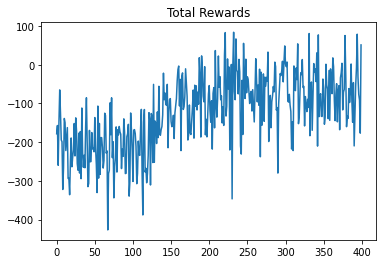

In [12]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show() 

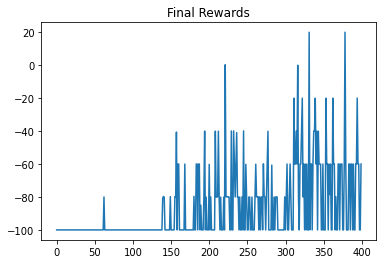

In [13]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

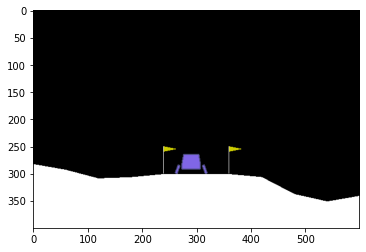

In [18]:
# 測試前先將 network 切換為 evaluation 模式
agent.pgnet.eval()
agent.vfnet.eval()

state = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

total_reward = 0

done = False
while not done:
    action, _ = agent.sample(state)
    state, reward, done, _ = env.step(action)

    total_reward += reward

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [21]:
print(total_reward)

256.9038863428915
